# Extensión de la API de Pandas

In [4]:
import itertools
import pandas as pd
import upsetplot

In [6]:
try:
    del pd.DataFrame.missing
except AttributeError:
    pass

In [7]:
@pd.api.extensions.register_dataframe_accessor("missing")
class MissingMethods:
    def __init__(self, pandas_obj):
        self._obj = pandas_obj

    def number_missing(self) -> int:
        return self._obj.isna().sum().sum()

    def number_complete(self) -> int:
        return self._obj.size - self._obj.missing.number_missing()

    def missing_variable_summary(self) -> pd.DataFrame:
        return self._obj.isnull().pipe(
            lambda df_1: (
                df_1.sum()
                .reset_index(name="n_missing")
                .rename(columns={"index": "variable"})
                .assign(
                    n_cases=len(df_1),
                    pct_missing=lambda df_2: df_2.n_missing / df_2.n_cases * 100,
                )
            )
        )

    def missing_case_summary(self) -> pd.DataFrame:
        return self._obj.assign(
            case=lambda df: df.index,
            n_missing=lambda df: df.apply(
                axis="columns", func=lambda row: row.isna().sum()
            ),
            pct_missing=lambda df: df["n_missing"] / df.shape[1] * 100,
        )[["case", "n_missing", "pct_missing"]]

    def missing_variable_table(self) -> pd.DataFrame:
        return (
            self._obj.missing.missing_variable_summary()
            .value_counts("n_missing")
            .reset_index(name="n_variables")
            .rename(columns={"n_missing": "n_missing_in_variable"})
            .assign(
                pct_variables=lambda df: df.n_variables / df.n_variables.sum() * 100
            )
            .sort_values("pct_variables", ascending=False)
        ) 

    def missing_case_table(self) -> pd.DataFrame():
        return (
            self._obj.missing.missing_case_summary()
            .value_counts("n_missing")
            .reset_index(name="n_cases")
            .rename(columns={"n_missing": "n_missing_in_case"})
            .assign(pct_case=lambda df: df.n_cases / df.n_cases.sum() * 100)
            .sort_values("pct_case", ascending=False)
        )

    def missing_variable_span(self, variable: str, span_every: int) -> pd.DataFrame:
        return (
            self._obj.assign(
                span_counter=lambda df: (
                    np.repeat(a=range(df.shape[0]), repeats=span_every)[: df.shape[0]]
                )
            )
            .groupby("span_counter")
            .aggregate(
                n_in_span=(variable, "size"),
                n_missing=(variable, lambda s: s.isnull().sum()),
            )
            .assign(
                n_complete=lambda df: df.n_in_span - df.n_missing,
                pct_missing=lambda df: df.n_missing / df.n_in_span * 100,
                pct_complete=lambda df: 100 - df.pct_missing,
            )
            .drop(columns=["n_in_span"])
            .reset_index()
        )

    def missing_variable_run(self, variable) -> pd.DataFrame:
        rle_list = self._obj[variable].pipe(
            lambda s: [[len(list(g)), k] for k, g in itertools.groupby(s.isnull())]
        )

        return pd.DataFrame(data=rle_list, columns=["run_length", "is_na"]).replace(
            {False: "complete", True: "missing"}
        )

    def sort_variables_by_missingness(self, ascending = False):

        return (
            self._obj
            .pipe(
                lambda df: (
                    df[df.isna().sum().sort_values(ascending = ascending).index]
                )
            )
        )

    def create_shadow_matrix(
        self,
        true_string: str = "Missing",
        false_string: str = "Not Missing",
        only_missing: bool = False,
    ) -> pd.DataFrame:
        return (
            self._obj
            .isna()
            .pipe(lambda df: df[df.columns[df.any()]] if only_missing else df)
            .replace({False: false_string, True: true_string})
            .add_suffix("_NA")
        )

    def bind_shadow_matrix(
        self,
        true_string: str = "Missing",
        false_string: str = "Not Missing",
        only_missing: bool = False,
    ) -> pd.DataFrame:
        return pd.concat(
            objs=[
                self._obj,
                self._obj.missing.create_shadow_matrix(
                    true_string=true_string,
                    false_string=false_string,
                    only_missing=only_missing
                )
            ],
            axis="columns"
        )

    def missing_scan_count(self, search) -> pd.DataFrame:
        return (
            self._obj.apply(axis="rows", func=lambda column: column.isin(search))
            .sum()
            .reset_index()
            .rename(columns={"index": "variable", 0: "n"})
            .assign(original_type=self._obj.dtypes.reset_index()[0])
        )

    # Plotting functions ---

    def missing_variable_plot(self):
        df = self._obj.missing.missing_variable_summary().sort_values("n_missing")

        plot_range = range(1, len(df.index) + 1)

        plt.hlines(y=plot_range, xmin=0, xmax=df.n_missing, color="black")

        plt.plot(np.array(df.n_missing), plot_range, 'o', color="black")
       
        plt.yticks(plot_range, df.variable)

        plt.grid(axis="y")

        plt.xlabel("Number missing")
        plt.ylabel("Variable")

    def missing_case_plot(self):

        df = self._obj.missing.missing_case_summary()

        sns.displot(data=df, x="n_missing", binwidth=1, color="black")

        plt.grid(axis="x")
        plt.xlabel("Number of missings in case")
        plt.ylabel("Number of cases")

    def missing_variable_span_plot(
        self, variable: str, span_every: int, rot: int = 0, figsize=None
    ):

        (
            self._obj.missing.missing_variable_span(
                variable=variable, span_every=span_every
            ).plot.bar(
                x="span_counter",
                y=["pct_missing", "pct_complete"],
                stacked=True,
                width=1,
                color=["black", "lightgray"],
                rot=rot,
                figsize=figsize,
            )
        )

        plt.xlabel("Span number")
        plt.ylabel("Percentage missing")
        plt.legend(["Missing", "Present"])
        plt.title(
            f"Percentage of missing values\nOver a repeating span of { span_every } ",
            loc="left",
        )
        plt.grid(False)
        plt.margins(0)
        plt.tight_layout(pad=0)

    def missing_upsetplot(self, variables: list[str] = None, **kwargs):

        if variables is None:
            variables = self._obj.columns.tolist()

        return (
            self._obj.isna()
            .value_counts(variables)
            .pipe(lambda df: upsetplot.plot(df, **kwargs))
        )

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=694a3d08-7f18-421d-9e2f-c2820a79680e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

Si también trabajas en VSCode, sigue este tutorial para importar pandas-missing-extension como un modulo para nuestro notebook principal:

Tutorial para Importar un Jupyter Notebook como Módulo en otro Notebook

Pasos Preliminares
Preparación del Entorno de Trabajo: Asegúrate de que tienes instalado Visual Studio Code y la extensión de Jupyter para este editor.
Organización de Archivos: Coloca el archivo notebook (pandas-missing-extension.ipynb) en la misma carpeta donde se encuentra el notebook en el que deseas importar el contenido.
Exportación del Notebook a un Script de Python
Exportar el Notebook:
Abre el archivo pandas-missing-extension.ipynb con Visual Studio Code.
Ve a la barra donde agregas bloques de código y el Kernell, selecciona ... > Exportar > Script de Python. Esto convertirá tu notebook en un script .py.
Guardado del Archivo Exportado:
Elige la carpeta donde deseas guardar el script. Si vas a importar el contenido en un notebook que se encuentra en la misma carpeta, guárdalo allí.
Dale al archivo exportado un nombre que cumpla con las convenciones de nombres de Python (sin guiones). Por ejemplo: pandas_missing_extension.py.
Importación del Módulo en el Notebook Destino
Importar el Módulo:
Vuelve al notebook en el que deseas utilizar las funciones o clases definidas en pandas-missing-extension.ipynb.
En una celda nueva, escribe el comando de importación utilizando el nombre correcto del archivo script de Python, por ejemplo: import pandas_missing_extension
Verificación y Uso del Módulo Importado
Usar el Módulo:

Una vez importado el módulo, puedes acceder a las funciones, clases y variables definidas dentro de él.
Por ejemplo, si pandas-missing-extension.ipynb tenía una función llamada clean_data, puedes usarla así:pythonCopy codecleaned_data = pandas_missing_extension.clean_data(raw_data)
Manejo de Errores:

Si encuentras errores al intentar usar el módulo, verifica que todas las dependencias necesarias estén instaladas y que las rutas a los archivos sean correctas.
Prueba del Código:

Ejecuta las celdas para asegurarte de que la importación y el uso del módulo sean exitosos.
Consejos Finales
Mantén una estructura de carpetas limpia y bien organizada para facilitar la importación y el mantenimiento del código.
Asegúrate de documentar el proceso dentro de tus notebooks para que otros puedan seguir tus pasos.
Este tutorial te ayudará a importar eficientemente el contenido de un notebook de Jupyter en otro, utilizando Visual Studio Code, de una manera que es fácil de seguir y de replicar en el futuro.

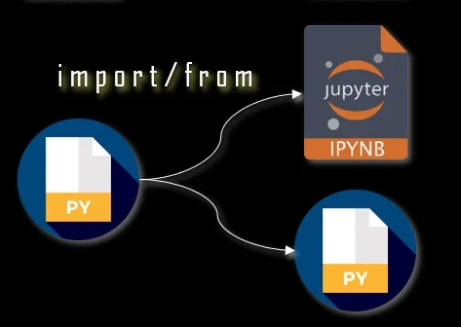

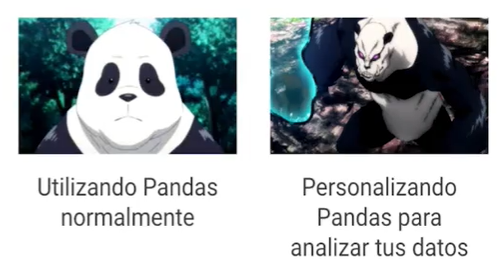